<Quantity 52.43763337 ms>

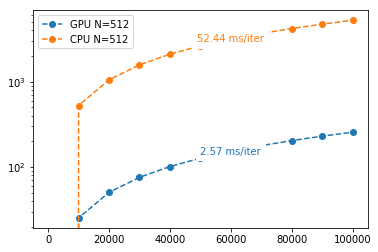

In [88]:
import h5py
import json
import os
import astropy.units as u
from labellines import labelLine
import pandas as pd
import pathlib

def plot_times(name, directory, color ="", plot=False):
    paths = os.listdir(directory)
    paths = list(filter(lambda x: "data" in x, paths))

    def get_dict(path):
        with h5py.File(path, "r") as f:
            d = dict(f.attrs)
        return d

    df = pd.DataFrame({path: get_dict(os.path.join(directory, path)) for path in paths}).T
    df["iteration"] = pd.Series(df.index.str.lstrip('data').str.rstrip('.h5').astype(int), df.index, )
    df["time"] = df["time"].astype(float)

    poly = np.poly1d(np.polyfit(df.iteration.values, df.time.values, 1))
    time_per_iter = (poly.coef[0] * u.s).to(u.ms)
    if plot:
        line_label = f"{time_per_iter:0.2f}/iter"
    
        line = plt.semilogy(df.iteration.values, df.time.values - df.time.min(), f"{color}o--", label=name)[-1]
        labelLine(line, 6e4, label=line_label, align=False)
#         labelLine(l1,0.6,label=r'$Re=${}'.format(l1.get_label()),ha='left',va='bottom',align = False)
        plt.legend()
        plt.grid()
    return time_per_iter
    
plot_times("GPU N=512", "/mnt/hdd/data/gpu512/", plot=True)
plot_times("CPU N=512", "/mnt/hdd/data/cpu512/", plot=True)

{'cpu512': <Quantity 52.43763337 ms>,
 'cpu64': <Quantity 0.71512524 ms>,
 'cpu8': <Quantity 0.07362502 ms>,
 'gpu512': <Quantity 2.5671275 ms>,
 'gpu64': <Quantity 1.28820434 ms>,
 'gpu8': <Quantity 1.236806 ms>}

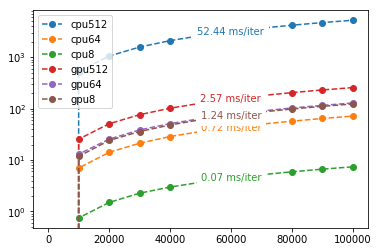

In [96]:
root = pathlib.Path("/mnt/hdd/data/")

paths = [d for d in root.iterdir() if d.is_dir() if ("cpu" in d.name or "gpu" in d.name and "4096" not in d.name)]
def sort_key(s):
    return int(s.lstrip("gcpu"))
d = {path.name: plot_times(path.name, path, plot=True) for path in paths}
d

In [97]:
cpu = {k: v for k, v in d.items() if "cpu" in k}
gpu = {k: v for k, v in d.items() if "gpu" in k}

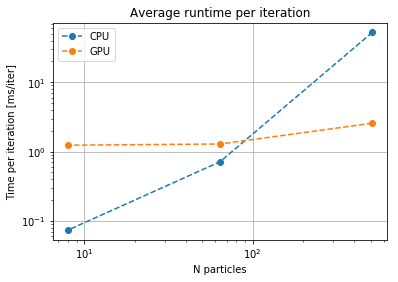

In [95]:
plt.loglog([sort_key(k) for k in cpu], [x.value for x in cpu.values()], "o--", label="CPU")
plt.loglog([sort_key(k) for k in gpu], [x.value for x in gpu.values()], "o--", label="GPU")
plt.legend()
plt.xlabel("N particles")
plt.ylabel("Time per iteration [ms/iter]")
plt.title("Average runtime per iteration")
plt.grid()

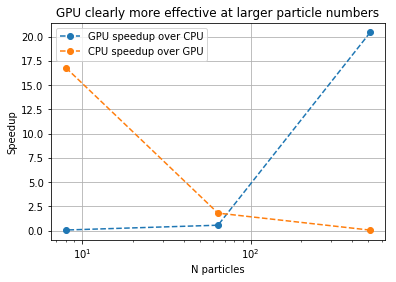

In [110]:
plt.semilogx([sort_key(k) for k in cpu], [x.value/y.value for x, y in zip(cpu.values(), gpu.values())], "o--", label="GPU speedup over CPU")
plt.semilogx([sort_key(k) for k in cpu], [y.value/x.value for x, y in zip(cpu.values(), gpu.values())], "o--", label="CPU speedup over GPU")
plt.xlabel("N particles")
plt.ylabel("Speedup")
plt.grid()
plt.title("GPU clearly more effective at larger particle numbers")
plt.legend()

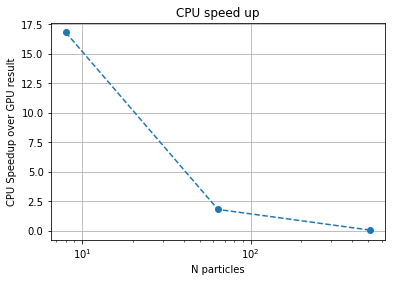

In [104]:
plt.semilogx([sort_key(k) for k in cpu], [y.value/x.value for x, y in zip(cpu.values(), gpu.values())], "o--", label="")
# plt.legend()
plt.xlabel("N particles")
plt.ylabel("CPU Speedup over GPU result")
plt.grid()
plt.title("CPU speed up");